# Check the device

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Download CIFAR-10 and build dataloader

In [2]:
import torchvision
import torchvision.transforms as transforms

train_data = torchvision.datasets.CIFAR10(root='./datasets',
                                        train=True,
                                        transform=transforms.ToTensor(),
                                        download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets


In [3]:
len(train_data)

50000

In [4]:
BATCH_SIZE = 20
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

In [5]:
image, label = next(iter(train_loader))
print(image.shape)
print(image.shape[-1])
print(len(train_loader))

torch.Size([20, 3, 32, 32])
32
2500


# Define CNN model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torchsummary as summary

In [7]:
class CNN(nn.Module):
  def __init__(self, in_channel, n_classes=10):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channel, 6, 5, stride=1, padding=2),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        # (32, 32) -> (16, 16)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6, 16, 3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        # (16, 16) -> (8, 8)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(16, 32, 3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
        # (8, 8) -> (4, 4)
    )
    self.layer4 = nn.Linear(4*4*32, 120)
    self.layer5 = nn.Linear(120, 84)
    self.fc = nn.Linear(84, n_classes)

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = x.reshape(x.size(0),-1)
    x = F.relu(self.layer4(x))
    x = F.relu(self.layer5(x))
    x = F.softmax(self.fc(x))
    return x

In [19]:
import os, sys
import numpy as np
import random

def fix_seeds(seed = 42, use_torch=False):
    # fix the seed for reproducibility 
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

    if use_torch: 
        torch.manual_seed(seed) 
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

In [20]:
def show_model_summary(model):
    print('{:=^60}'.format("="))
    print('{:^60}'.format("model summary"))
    print('{:=^60}'.format("="))
    for param_tensor in model.state_dict():
        print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
    print('{:=^60}'.format("="))

In [21]:
def init_weights(m):
    # initialize the weight, bias
    if isinstance(m, nn.Conv2d):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        if m.bias is not None:
            torch.nn.init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight.data, mean=1, std=0.02)
        torch.nn.init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight.data)
        torch.nn.init.normal_(m.bias.data)

# train the model

In [22]:
model = CNN(in_channel=image.shape[1], n_classes=10).to(device)

fix_seeds(seed=42, use_torch=True)
# weight initialize
model.apply(init_weights)

show_model_summary(model)

learning_rate = 1e-4
EPOCHS = 100

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
steps = len(train_loader)
train_loss = []

for epoch in range(1, EPOCHS + 1):
    total_loss, cnt = 0, 0
    for i, (image, label) in enumerate(train_loader, 1):
        image = image.to(device)
        label = label.to(device)

        output = model(image)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss)
        total_loss += loss.item()
        cnt += 1

        if i % (steps / 5) == 0:
            avg_loss = total_loss / cnt
            print(f'Epoch: [{epoch}/{EPOCHS}], Batch steps: [{i}|{steps}] Average Loss: {avg_loss:.4f}')
            total_loss, cnt = 0, 0
    print()

                       model summary                        
layer1.0.weight                   torch.Size([6, 3, 5, 5])   
layer1.0.bias                         torch.Size([6])        
layer1.1.weight                       torch.Size([6])        
layer1.1.bias                         torch.Size([6])        
layer1.1.running_mean                 torch.Size([6])        
layer1.1.running_var                  torch.Size([6])        
layer1.1.num_batches_tracked           torch.Size([])        
layer2.0.weight                  torch.Size([16, 6, 3, 3])   
layer2.0.bias                         torch.Size([16])       
layer2.1.weight                       torch.Size([16])       
layer2.1.bias                         torch.Size([16])       
layer2.1.running_mean                 torch.Size([16])       
layer2.1.running_var                  torch.Size([16])       
layer2.1.num_batches_tracked           torch.Size([])        
layer3.0.weight                  torch.Size([32, 16, 3, 3])  
layer3.0.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: [1/100], Batch steps: [500|2500] Average Loss: 2.2323
Epoch: [1/100], Batch steps: [1000|2500] Average Loss: 2.1647
Epoch: [1/100], Batch steps: [1500|2500] Average Loss: 2.1155
Epoch: [1/100], Batch steps: [2000|2500] Average Loss: 2.0817
Epoch: [1/100], Batch steps: [2500|2500] Average Loss: 2.0649

Epoch: [2/100], Batch steps: [500|2500] Average Loss: 2.0523
Epoch: [2/100], Batch steps: [1000|2500] Average Loss: 2.0414
Epoch: [2/100], Batch steps: [1500|2500] Average Loss: 2.0378
Epoch: [2/100], Batch steps: [2000|2500] Average Loss: 2.0245
Epoch: [2/100], Batch steps: [2500|2500] Average Loss: 2.0316

Epoch: [3/100], Batch steps: [500|2500] Average Loss: 2.0121
Epoch: [3/100], Batch steps: [1000|2500] Average Loss: 2.0145
Epoch: [3/100], Batch steps: [1500|2500] Average Loss: 2.0068
Epoch: [3/100], Batch steps: [2000|2500] Average Loss: 2.0028
Epoch: [3/100], Batch steps: [2500|2500] Average Loss: 1.9998

Epoch: [4/100], Batch steps: [500|2500] Average Loss: 1.9836
Epoch: [4

# print the train loss

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

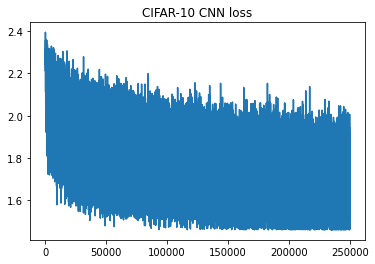

In [24]:
plt.plot(train_loss)
plt.title("CIFAR-10 CNN loss")
plt.show()

# save the trained model

In [25]:
torch.save(model, 'model.pth')

# load the test data

In [26]:
test_data = torchvision.datasets.CIFAR10(root='./datasets',
                                       train=False,
                                       transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True)

# load the trained model and test

In [27]:
model = torch.load('model.pth')
model.eval()
acc = 0

for image, label in test_loader:
    image = image.to(device)
    label = label.to(device)

    _, preds = torch.max(model(image.data), 1)
    for (pred, ans) in zip(preds, label):
        if pred == ans:
            acc += 1
    acc = acc / len(preds)
print(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0.9397233428044665
